In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import string
import skimpy
from ydata_profiling import ProfileReport
import re
import nltk
import missingno as msno
import datetime
import time
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import sys
sys.path.append("/home/alexxgo21/workspace/Thesis/modules")

from preprocess_raw_html import preprocess_raw_html


import warnings
warnings.filterwarnings("ignore")
# nltk.download('omw-1.4', quiet=True)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None) 

### Load the dataset

In [2]:
df = pd.read_parquet("../dataset/philosophy-qna-with-gpt35answer.parquet")

In [3]:
df["answer"] = df["answer"].apply(lambda x : [preprocess_raw_html(ans) for ans in x[0]])
df["question"] = df["question"].apply(lambda x : preprocess_raw_html(x))
df["gpt35_answer"] = df["gpt35_answer"].apply(lambda x : x["choices"][0]["message"]["content"])
df["gpt35_answer"] = df["gpt35_answer"].apply(lambda x : re.sub(r"\n", " ", x))

In [6]:
test = df[["question","gpt35_answer","answer"]]

In [9]:
test["answer"] = test["answer"].apply(lambda x : " ; ".join([f"({i+1}){ans}" for i, ans in enumerate(x)]))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   question_id                                               1308 non-null   int64  
 1   is_accepted                                               1308 non-null   object 
 2   answer_score                                              1308 non-null   object 
 3   answer_creation_date                                      1308 non-null   object 
 4   answer                                                    1308 non-null   object 
 5   owner__account_id                                         1234 non-null   float64
 6   owner__reputation                                         1234 non-null   float64
 7   owner__user_id                                            1234 non-null   float64
 8   owner__user_type  

In [4]:
# profile = ProfileReport(df,explorative=True)
# profile.to_file("profile.html")

### Check for missing values

<Axes: >

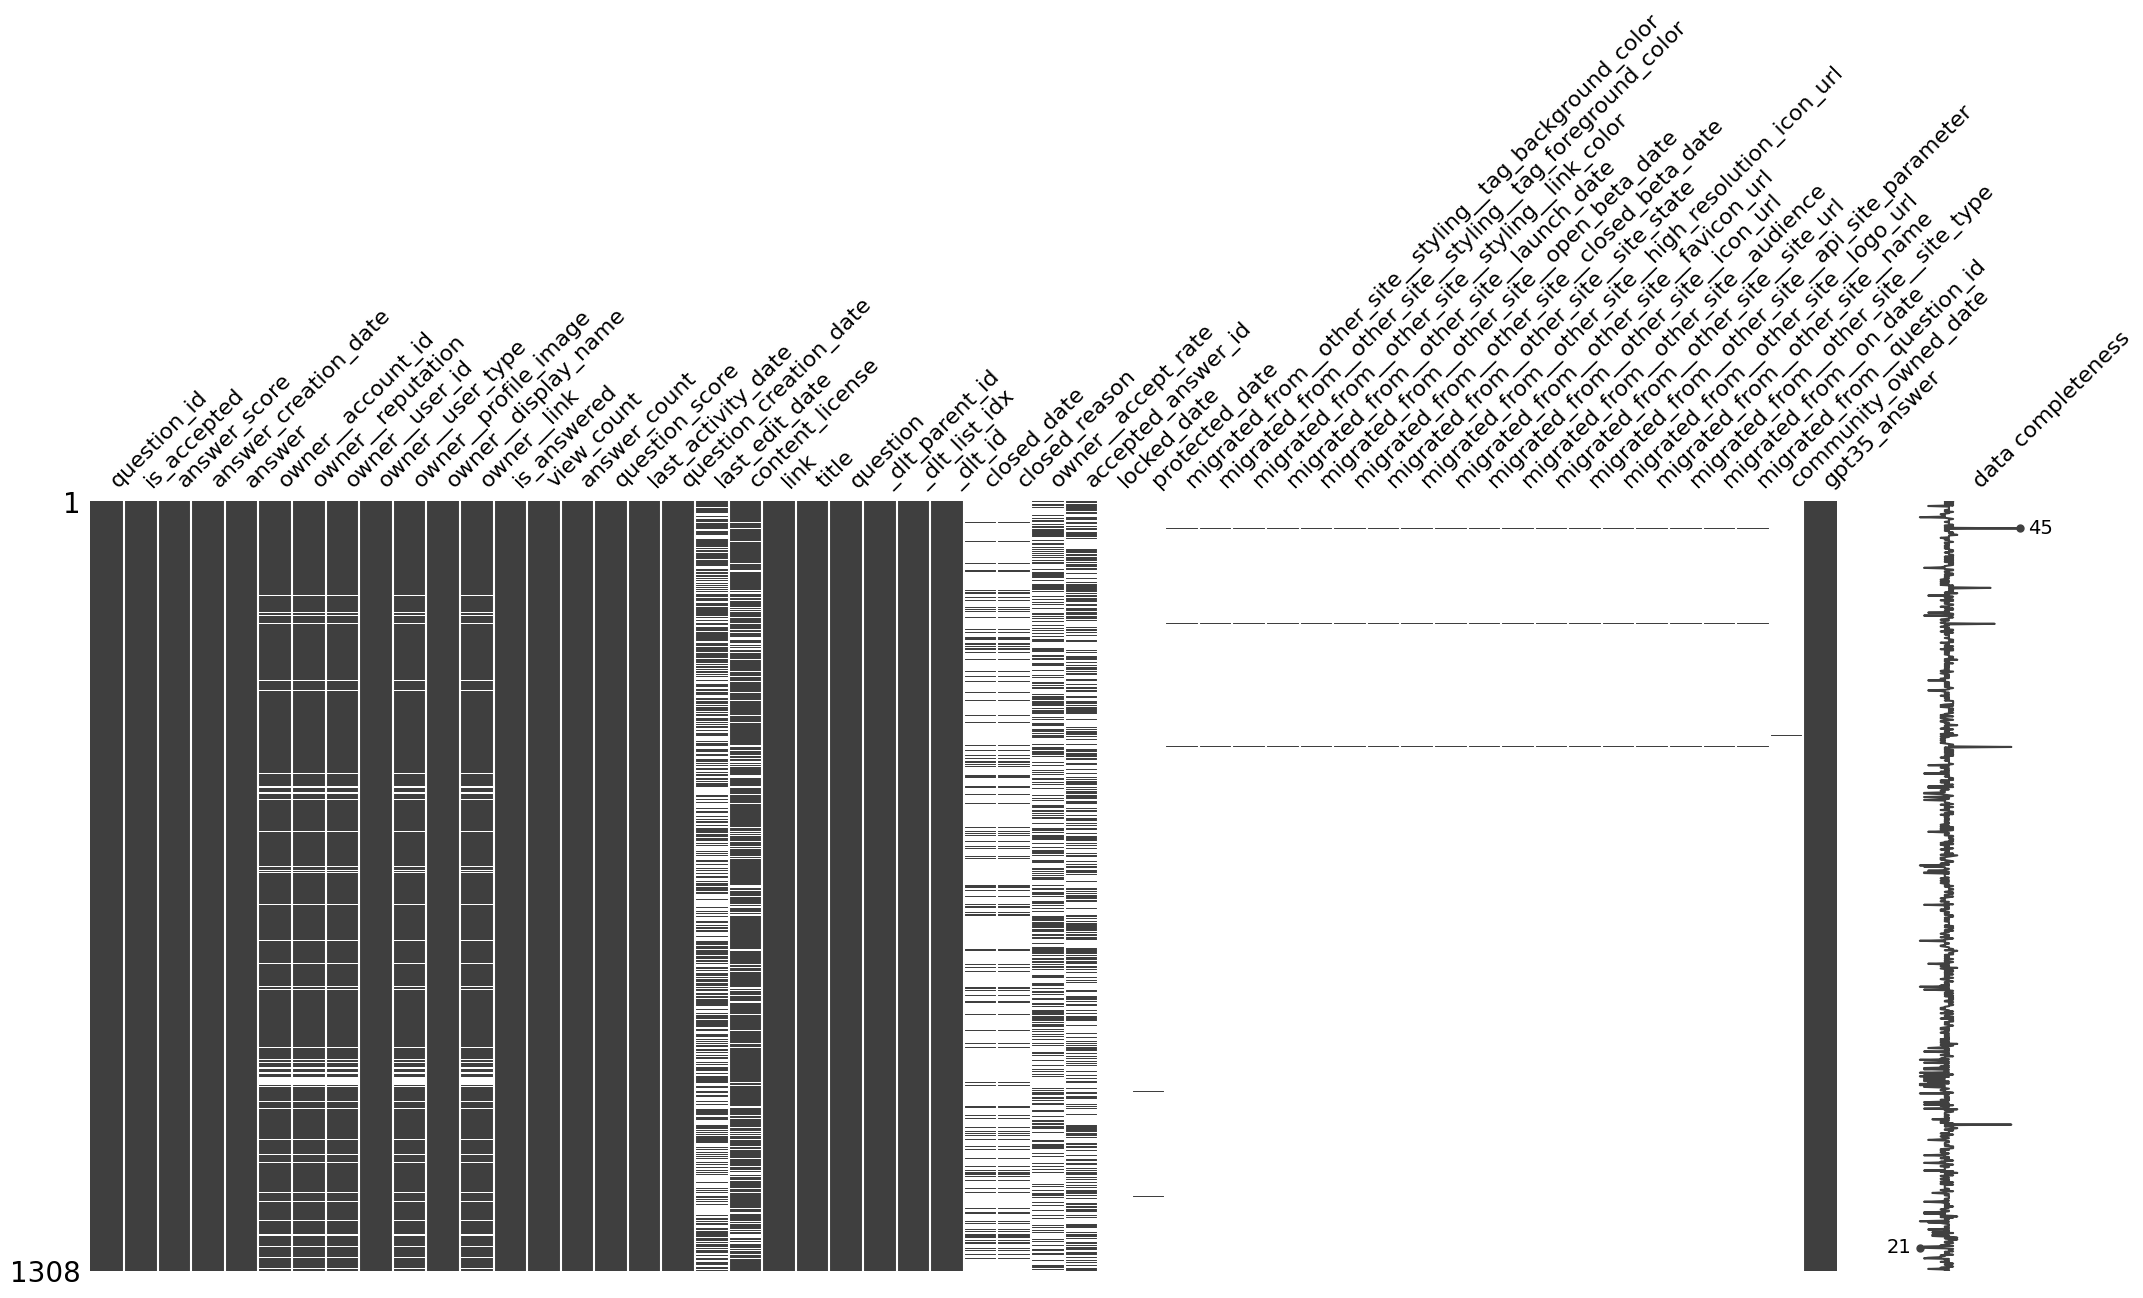

In [5]:
msno.matrix(df,labels=True)

### Get the related columns for further analysis

In [3]:
df = df[["view_count","answer_count","is_accepted","answer_score","answer_creation_date","answer","question_score","question_creation_date","link","question","title","gpt35_answer"]]

In [7]:
df.head(n=1)

view_count  answer_count                                  is_accepted  \
0        1873             6  [[False, False, True, False, False, False]]   

            answer_score  \
0  [[-1, 4, 6, 4, 1, 3]]   

                                                         answer_creation_date  \
0  [[1369382427, 1333109853, 1319736619, 1319696555, 1319584440, 1307574570]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

##### Questions date range

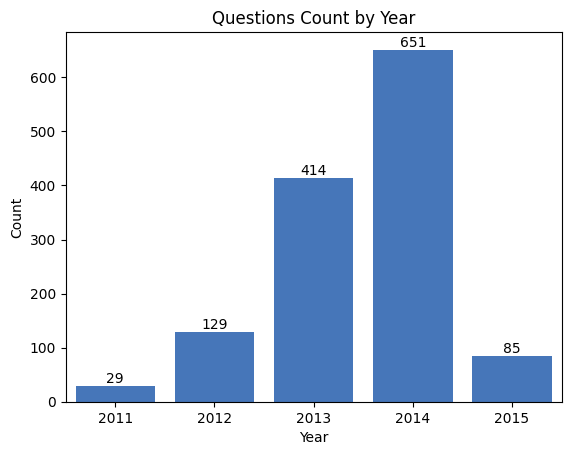

In [8]:
questions_date = df["question_creation_date"]
questions_date = questions_date.apply(lambda x: datetime.datetime.fromtimestamp(x))
year = Counter(list(questions_date.dt.year))

ax = sns.barplot(x=list(year.keys()),y=list(year.values()),errwidth=0,color="#3373cc")
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Questions Count by Year")
plt.show()

##### Answer count

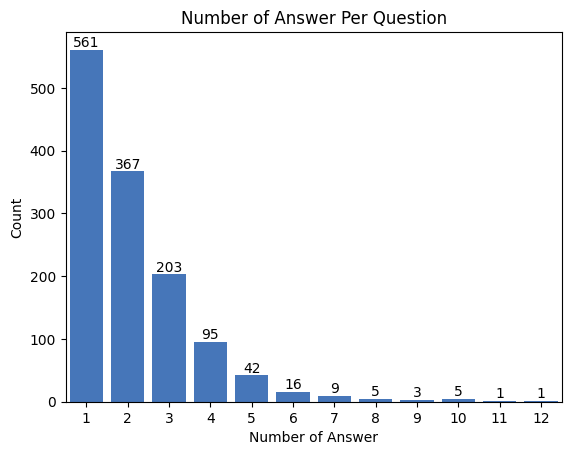

In [9]:
answer_count_per_question = df["answer_count"]
answer_count_per_question = Counter(list(answer_count_per_question))

ax = sns.barplot(x=list(answer_count_per_question.keys()),y=list(answer_count_per_question.values()),errwidth=0,color="#3373cc")
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel("Number of Answer")
plt.ylabel("Count")
plt.title("Number of Answer Per Question")
plt.show()

##### Questions score

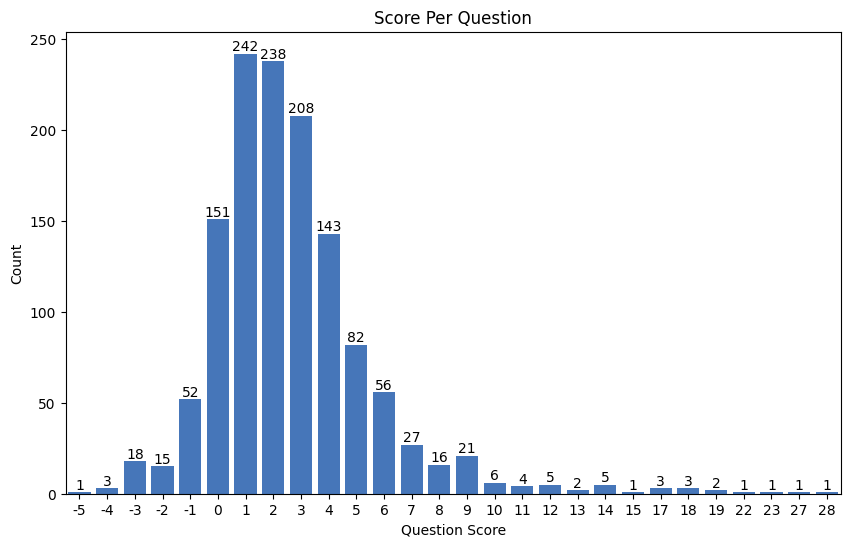

In [10]:
question_score = df["question_score"]
question_score = Counter(list(question_score))
plt.figure(figsize=(10,6))
ax = sns.barplot(x=list(question_score.keys()),y=list(question_score.values()),errwidth=0,color="#3373cc")
for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel("Question Score")
plt.ylabel("Count")
plt.title("Score Per Question")
plt.show()

# Exploratory Data Analysis

In [4]:
ans = df["answer"].apply(lambda x : x[0]).to_list()
ans = [preprocess_raw_html(answer) for sublist in ans for answer in sublist]

In [5]:
gpt_ans = df["gpt35_answer"].to_list() 
gpt_ans = [re.sub(r"\n", " ", text["choices"][0]["message"]["content"]) for text in gpt_ans]

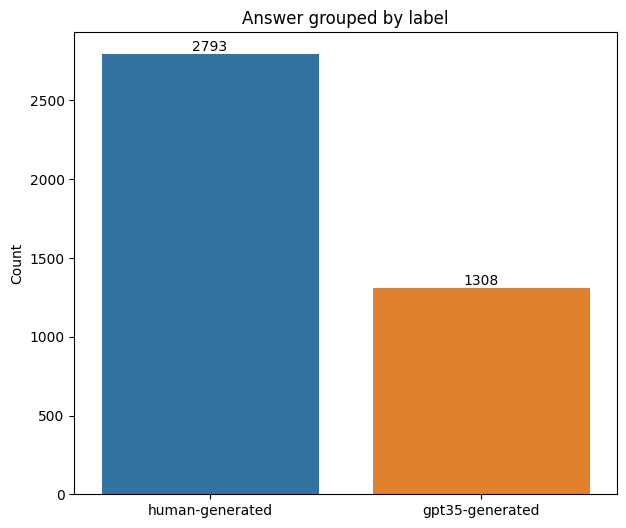

In [13]:
plt.figure(figsize=(7,6))
ax = sns.barplot(y=[len(ans),len(gpt_ans)],x=["human-generated","gpt35-generated"],errwidth=0)
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Count")
plt.title("Answer grouped by label")
plt.show()

In [6]:
ds = pd.concat([pd.DataFrame({"answer":ans,"label":["human-generated" for i in range(len(ans))]}),pd.DataFrame({"answer":gpt_ans,"label":["gpt35-generated" for i in range(len(gpt_ans))]})],ignore_index=True)
ds = ds.sample(frac=1)

In [15]:
ds.head(3)

,answer,label
3477,"Certainly, it is possible to engage in philosophical thought experiments and arguments that question the existence or knowability of infinities in the real world without relying on the physical finiteness of the universe. There are various philosophical positions and arguments that can be used to challenge the notion of infinite knowledge or infinite entities. Here are a few ways one might approach this issue: 1. Epistemic Limitation: One argument against the possibility of knowing an infinite amount of things is based on the limitations of the human mind or consciousness. Some philosophers argue that our cognitive capacities are finite, and therefore we are incapable of comprehending or knowing all possible knowledge or truths. This view suggests that even if there were an infinite number of knowable things, our finite minds would be unable to grasp them all. 2. Skepticism About Infinities: Some philosophers are skeptical about the concept of actual infinities, arguing that it leads to paradoxes or conceptual difficulties. For example, the idea of an infinite number of things may raise questions about how such a totality could be logically coherent or well-defined. By challenging the coherence or intelligibility of infinity, one could cast doubt on the notion that an infinite amount of knowledge is achievable. 3. Empirical Justification: Another approach might be to argue that empirical evidence or observation does not support the claim that there are infinite entities or knowledge. Without concrete evidence or justification for the existence of infinities in the real world, one could question the certainty of such claims. It is important to note that these arguments are philosophical in nature and do not rely on empirical evidence or scientific observations about the physical world. By engaging with these philosophical perspectives, one can explore different ways of thinking about the limits of knowledge and the concept of infinity without invoking the physical finiteness of the universe.",gpt35-generated
1239,"The question whether P=NP has no bearing on whether processes are deterministic are not, only on the relative amount of effort that deterministic vs. nondeterministic stepwise processes may take to arrive at solutions to particular types of problems. The nondeterminism considered is always limited to a finite, enumerable choice of alternatives, so for any of the nondeterministic processes considered, a deterministic 'equivalent' always exists (e.g. obtained by exhaustively trying out all alternatives in some systematic way).",human-generated
3368,"It seems like you are referring to some paradoxical statements made by the ancient Chinese philosopher Kung-sun Lung, who was a sophist and contemporary of Confucius. His statements are known for their paradoxical and enigmatic nature, much like the famous paradoxes of Zeno in Greek philosophy. The statement ""A white horse isn't a horse"" can be seen as a play on words and a commentary on the nature of identity and categorization. It challenges the idea that the general concept of a horse can be equated with a specific instance of a white horse, suggesting that there is a distinction between a particular instance and the general category it belongs to. As for the statement ""A brown horse and a dark ox are three together,"" this statement seems to present a similar type of paradox by playing with the concept of counting or perception of numbers. Without the original context or reference, it is difficult to provide a definitive interpretation. However, it could be interpreted as a demonstration of how language and categorization can lead to logical contradictions or paradoxes. Sophists like Kung-sun Lung were known for their use of rhetoric, argumentation, and paradoxical statements to challenge established beliefs and provoke critical thinking. Their goal was often to highlight the limitations of language and logic and to question commonly accepted truth

### Length and Word Count Distribution

In [7]:
def word_count(ans):
    return len(ans.split())

ds["length"] = ds["answer"].str.len()
ds["word_count"] = ds["answer"].apply(word_count)
ds["mean_sentence_len"] = ds["answer"].map(lambda ans: np.mean([len(s) for s in tokenize.sent_tokenize(ans)]))

In [17]:
def visualize(col):
    print()
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.boxplot(y=ds[col])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(ds[ds["label"]=="human-generated"][col])
    sns.kdeplot(ds[ds["label"]=="gpt35-generated"][col])
    plt.legend(ds["label"].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

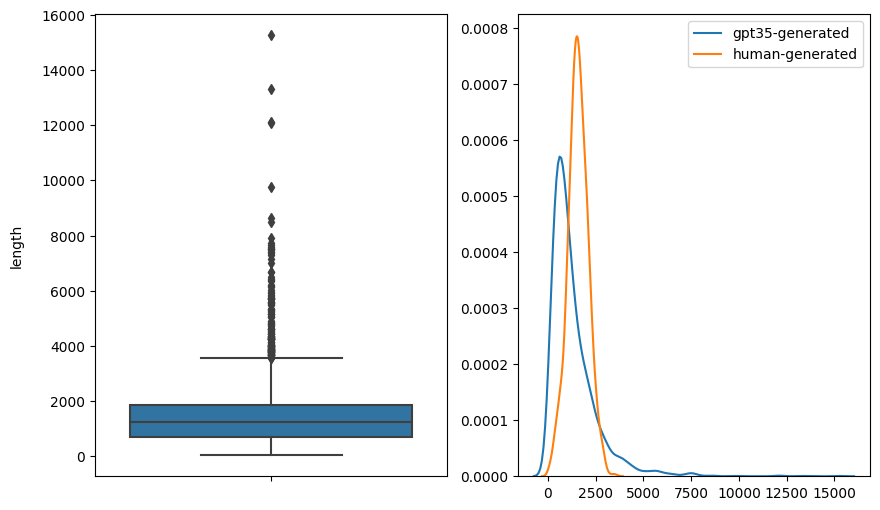

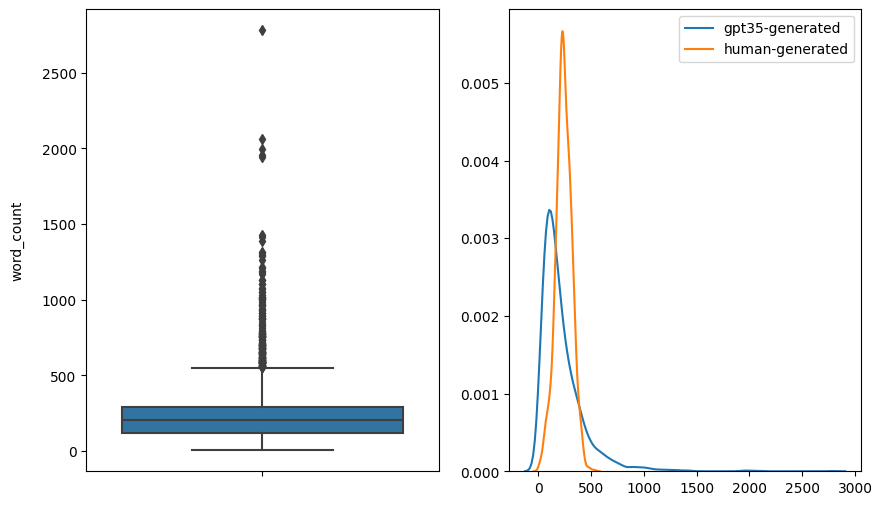

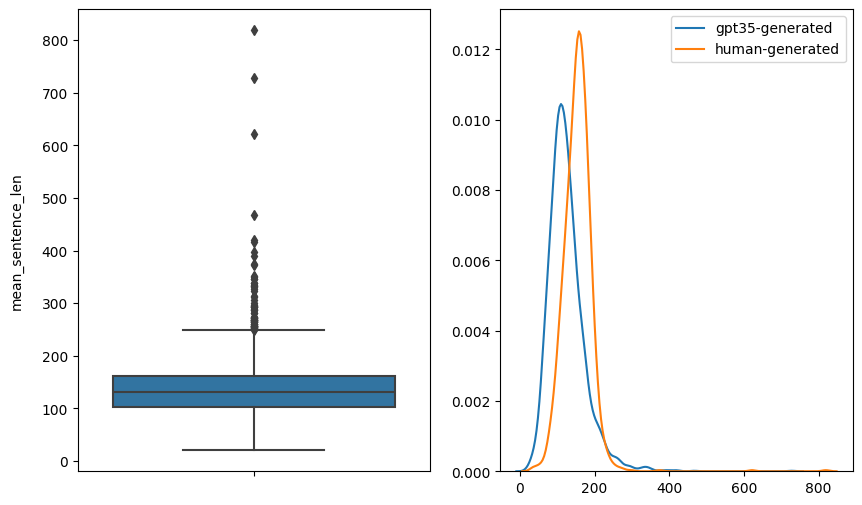

In [18]:
for col in ds.columns[2:]:
    visualize(col)

In [7]:
# function to clean raw text
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^0-9a-zA-Z]+", " ", text)
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    
    return text

In [9]:
ds["answer_word_list"] = ds["answer"].apply(lambda x:preprocess_text(x).split())

In [21]:
corpus = []
for i in trange(ds.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += ds["answer_word_list"][i]
len(corpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4101/4101 [00:00<00:00, 191642.14it/s]


493483

In [22]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('one', 3759),
 ('would', 2708),
 ('may', 2596),
 ('philosophy', 2283),
 ('true', 1939),
 ('world', 1899),
 ('logic', 1838),
 ('question', 1826),
 ('like', 1821),
 ('theory', 1694)]

### Most Frequent Word

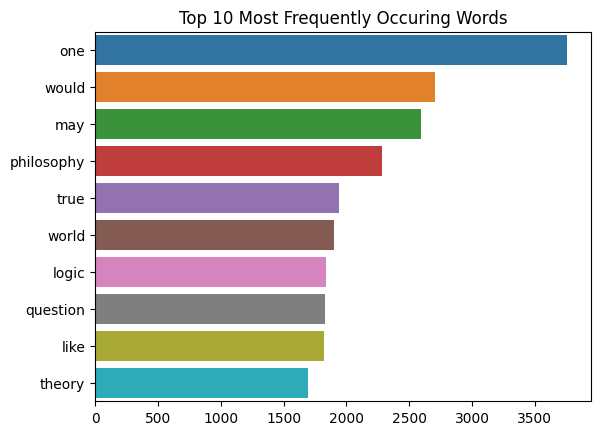

In [23]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title("Top 10 Most Frequently Occuring Words")
plt.show()

### Bigrams

In [24]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(ds["answer"].apply(preprocess_text))

In [25]:
count_values = bigrams.sum(axis=0)
count_values = np.array(count_values)[0]
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "n_gram"]

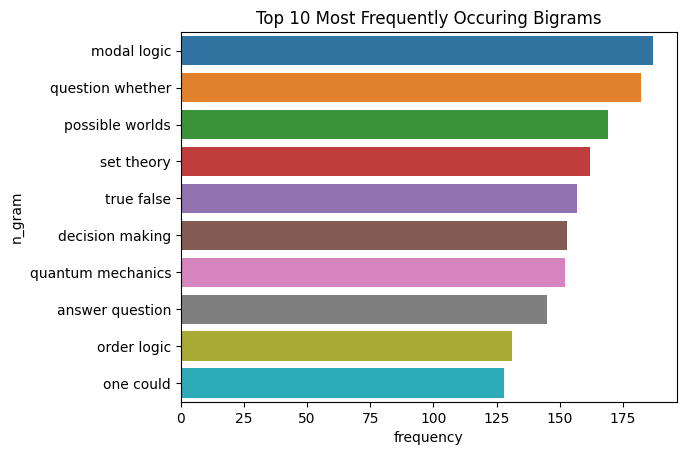

In [26]:
sns.barplot(x=ngram_freq["frequency"][:10], y=ngram_freq["n_gram"][:10])
plt.title("Top 10 Most Frequently Occuring Bigrams")    
plt.show()

### Trigrams

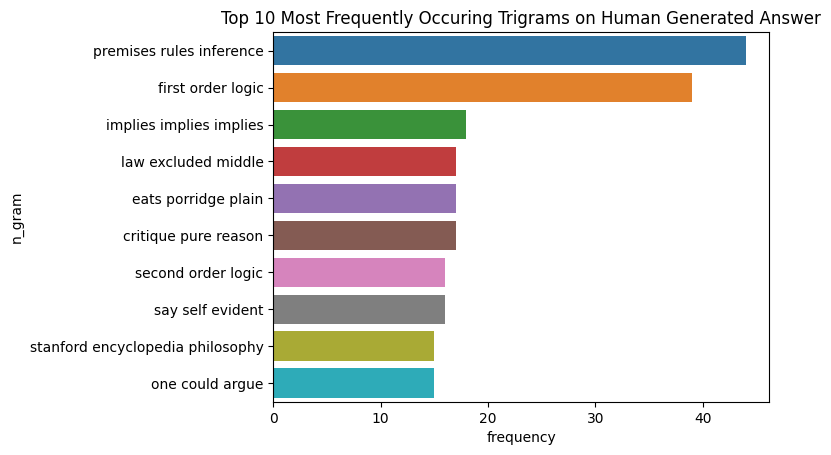

In [27]:
cv = CountVectorizer(ngram_range=(3,3))
trigrams = cv.fit_transform(ds[ds["label"]=="human-generated"]["answer"].apply(preprocess_text))
count_values = trigrams.sum(axis=0)
count_values = np.array(count_values)[0]
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "n_gram"]
sns.barplot(x=ngram_freq["frequency"][:10], y=ngram_freq["n_gram"][:10])
plt.title("Top 10 Most Frequently Occuring Trigrams on Human Generated Answer")
plt.show()

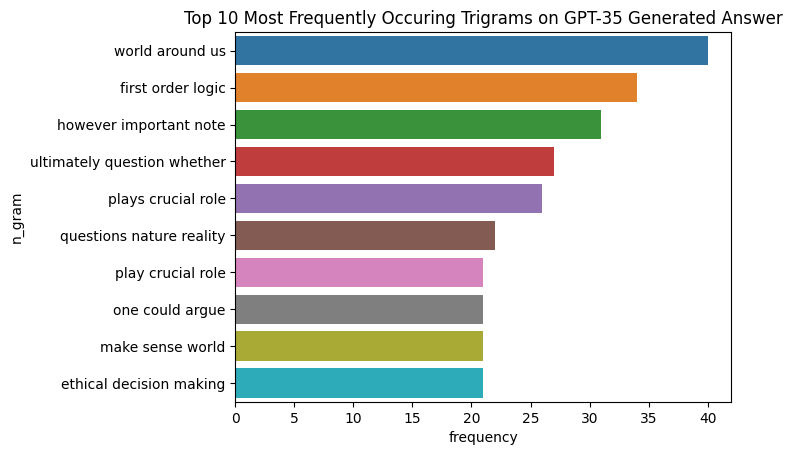

In [28]:
cv = CountVectorizer(ngram_range=(3,3))
trigrams = cv.fit_transform(ds[ds["label"]=="gpt35-generated"]["answer"].apply(preprocess_text))
count_values = trigrams.sum(axis=0)
count_values = np.array(count_values)[0]
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "n_gram"]
sns.barplot(x=ngram_freq["frequency"][:10], y=ngram_freq["n_gram"][:10])
plt.title("Top 10 Most Frequently Occuring Trigrams on GPT-35 Generated Answer")
plt.show()

### Modeling

### Traditional ML 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import random
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [30]:
feature_extraction = TfidfVectorizer()
X = feature_extraction.fit_transform(ds["answer"].apply(preprocess_text).values)
Y = ds["label"].values

# train test split using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X,Y):
    X_train, X_test = X[train_index], X[test_index] 
    Y_train, Y_test = Y[train_index], Y[test_index] 

# encode the label
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)

Y_train = label_encoder.transform(Y_train)
Y_test = label_encoder.transform(Y_test)

### Support Vector Machine

In [31]:
svc = SVC(probability=True)

# Hyperparameter grid
param_grid = {"C": [0.1, 1, 10], "kernel": ["rbf","sigmoid","polynomial"], "gamma":[0.1,1,10]}

# Grid search
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2)

# Fit and evaluate
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy) 
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  14.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  14.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.5s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  11.5s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  14.5s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  11.5s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  11.4s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  14.3s
[CV] END ................C=0.1, gamma=0.1, kernel=polynomial; total time=   0.0s
[CV] END ................C=0.1, gamma=0.1, kern

### Random Forest

In [32]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy) 
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END ma

### Gradient Boosting

In [33]:
gb = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy) 
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   8.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   5.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   5.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   6.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   6.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  15.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  12.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  15.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  12.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  11.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  17.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

### Deep Learning

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras_tuner
from keras.utils.vis_utils import plot_model

In [10]:
try:
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU is available.")
except RuntimeError:
    print("GPU is not available.")

print(tf.config.list_physical_devices('GPU'))

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
X,Y = np.array(ds["answer"].apply(preprocess_text).values), np.array(ds["label"].values)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X,Y):
    X_train, X_test = X[train_index], X[test_index] 
    Y_train, Y_test = Y[train_index], Y[test_index] 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in sss.split(X_test,Y_test):
    X_val, X_test = X_test[val_index], X_test[test_index]
    Y_val, Y_test = Y_test[val_index], Y_test[test_index] 

label_encoder = LabelEncoder()
label_encoder.fit(Y_train)

Y_train = label_encoder.transform(Y_train) 
Y_train = Y_train.reshape(Y_train.shape[0],1)

Y_val = label_encoder.transform(Y_val) 
Y_val = Y_val.reshape(Y_val.shape[0],1)

Y_test = label_encoder.transform(Y_test) 
Y_test = Y_test.reshape(Y_test.shape[0],1)

In [13]:
vocab_size = 10000
embedding_dim = 16
max_length = 500
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
validation_sequences = tokenizer.texts_to_sequences(X_val)  
testing_sequences = tokenizer.texts_to_sequences(X_test)

training_set = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
validation_set = pad_sequences(validation_sequences, maxlen=max_length)
testing_set = pad_sequences(testing_sequences, maxlen=max_length)

In [14]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)

In [15]:
# MLP with embedding layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")  
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(training_set, Y_train, epochs=100, validation_data=(validation_set, Y_val), batch_size=64, callbacks=[callback])

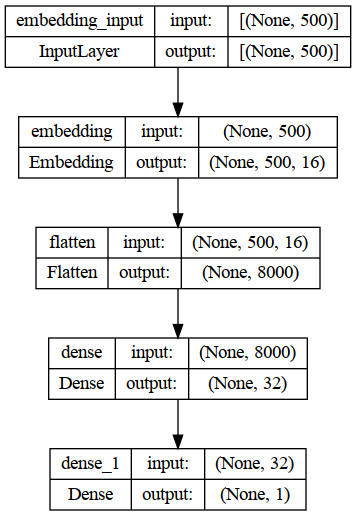

In [16]:
plot_model(model,show_shapes=True, show_layer_names=True)

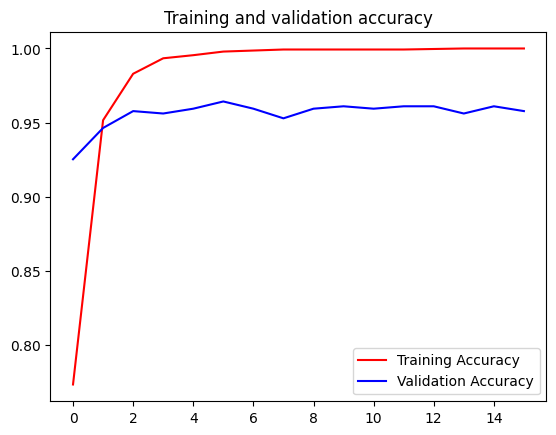

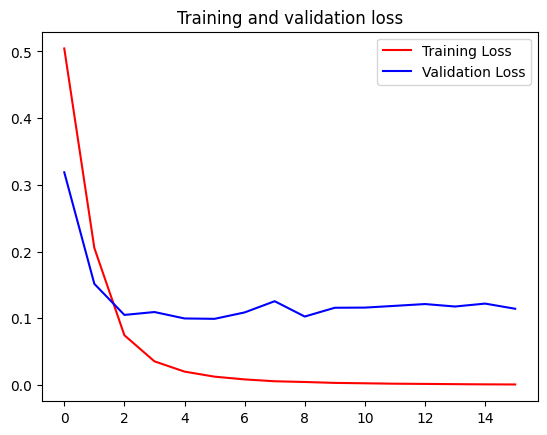

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r',label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
# Predict the labels for the testing set
Y_pred = model.predict(testing_set)
Y_pred = (Y_pred > 0.5).astype(int)  # Assuming a binary classification with a threshold of 0.5

# Calculate the classification report
report = classification_report(Y_test, Y_pred, target_names=label_encoder.classes_)
print(report)
print(confusion_matrix(Y_test,Y_pred))

20/20 [==============================] - 0s 4ms/step
                 precision    recall  f1-score   support

gpt35-generated       0.99      0.91      0.95       197
human-generated       0.96      1.00      0.98       419

       accuracy                           0.97       616
      macro avg       0.97      0.95      0.96       616
   weighted avg       0.97      0.97      0.97       616

[[180  17]
 [  2 417]]


### Hyperparameter Tuning with keras_tuner

In [18]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length))
    layer_type = hp.Choice("layer_type", ["conv1d", "lstm", "bilstm"])
    if layer_type=="conv1d":
        model.add(tf.keras.layers.Conv1D(filters=hp.Int("filters",min_value=32,max_value=128,step=32),kernel_size=5,activation="relu"))
    elif layer_type=="lstm":
        num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
        for i in range(int(num_layers)):
            if i<(int(num_layers)-1):
                model.add(tf.keras.layers.LSTM(hp.Int("units",min_value=32,max_value=64,step=32),return_sequences=True))
            else:
                model.add(tf.keras.layers.LSTM(hp.Int("units",min_value=32,max_value=64,step=32)))
    else:
        num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
        for i in range(int(num_layers)):
            if i<(int(num_layers)-1):
                model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int("units",min_value=32,max_value=64,step=32),return_sequences=True)))
            else:
                model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int("units",min_value=32,max_value=64,step=32))))

    if layer_type=="conv1d":
        layer_type = hp.Choice("layer_type", ["flatten", "global_avg_pooling", "max_pooling"])
        if layer_type=="flatten":
            model.add(tf.keras.layers.Flatten())
        elif layer_type=="global_avg_pooling":
            model.add(tf.keras.layers.GlobalAveragePooling1D())
        else:
            model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

    num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu"))
        if hp.Boolean('use_dropout'):
            model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',[0.001, 0.005, 0.01])), metrics=["accuracy"]) 

    return model 


In [19]:
tuner = keras_tuner.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparameter_tuning',
                     project_name='Sequence Model Hyperparameter Tuning')

# tuner.search(training_set, Y_train, epochs=100, validation_data=(validation_set, Y_val), batch_size=32, callbacks=[callback])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from hyperparameter_tuning/Sequence Model Hyperparameter Tuning/tuner0.json


In [17]:
tuner.search_space_summary()  
# tuner.results_summary()

Search space summary
Default search space size: 7
layer_type (Choice)
{'default': 'conv1d', 'conditions': [], 'values': ['conv1d', 'lstm', 'bilstm'], 'ordered': False}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
use_dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005, 0.01], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}


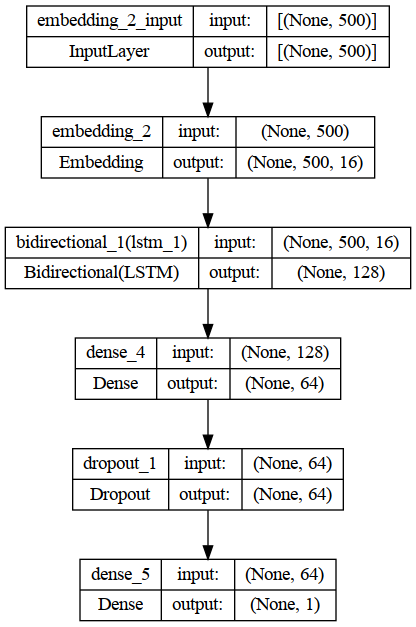

In [21]:
hypermodel = tuner.hypermodel.build(best_hps)
plot_model(hypermodel,show_shapes=True, show_layer_names=True)
# hypermodel.fit(training_set, Y_train, epochs=100, validation_data=(validation_set, Y_val), batch_size=64, callbacks=[callback])

In [19]:
# Predict the labels for the testing set
Y_pred = hypermodel.predict(testing_set)
Y_pred = (Y_pred > 0.5).astype(int)  # Assuming a binary classification with a threshold of 0.5

# Calculate the classification report
report = classification_report(Y_test, Y_pred, target_names=label_encoder.classes_)
print(report)
print(confusion_matrix(Y_test,Y_pred))

20/20 [==============================] - 1s 42ms/step
                 precision    recall  f1-score   support

gpt35-generated       0.98      0.89      0.93       197
human-generated       0.95      0.99      0.97       419

       accuracy                           0.96       616
      macro avg       0.96      0.94      0.95       616
   weighted avg       0.96      0.96      0.96       616

[[176  21]
 [  4 415]]


### Transformer Model with XLNet

In [10]:
from transformers import XLNetTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import XLNetForSequenceClassification
from transformers import AdamW, get_scheduler

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [22]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4101 entries, 2095 to 3531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   answer  4101 non-null   object
 1   label   4101 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.1+ KB


In [12]:
ds["answer"] = ds["answer"].apply(preprocess_text)
ds["label"] = ds["label"].apply(lambda x: 1 if x=="human-generated" else 0)

In [13]:
sentences = ds.answer.values
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
label = ds.label.values

In [14]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet/xlnet-base-cased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [15]:
MAX_LEN = 256
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [16]:
input_ids = np.array(input_ids)
label = np.array(label)
attention_masks = np.array(attention_masks)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(input_ids,label):
    train_inputs, validation_inputs = input_ids[train_index], input_ids[test_index] 
    train_labels, validation_labels = label[train_index], label[test_index] 
    train_masks, validation_masks = attention_masks[train_index], attention_masks[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for validation_index, test_index in sss.split(validation_inputs,validation_labels):
    validation_inputs, test_inputs = validation_inputs[validation_index], validation_inputs[test_index] 
    validation_labels, test_labels = validation_labels[validation_index], validation_labels[test_index] 
    validation_masks, test_masks = validation_masks[validation_index], validation_masks[test_index]


In [17]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(list(train_inputs))
validation_inputs = torch.tensor(list(validation_inputs))
test_inputs = torch.tensor(list(test_inputs))

train_labels = torch.tensor(list(train_labels))
validation_labels = torch.tensor(list(validation_labels))
test_labels = torch.tensor(list(test_labels))

train_masks = torch.tensor(list(train_masks))
validation_masks = torch.tensor(list(validation_masks))
test_masks = torch.tensor(list(test_masks))

batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [18]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet/xlnet-base-cased", num_labels=2)
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []

epochs = 5

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.22004440665865937


Epoch:  20%|██        | 1/5 [21:26<1:25:45, 1286.40s/it]

Validation Accuracy: 0.9322344322344321
Train loss: 0.05795544676236912


Epoch:  40%|████      | 2/5 [46:26<1:10:35, 1411.94s/it]

Validation Accuracy: 0.9807692307692307
Train loss: 0.020584060343228176


Epoch:  60%|██████    | 3/5 [1:10:25<47:28, 1424.30s/it]

Validation Accuracy: 0.9562728937728937
Train loss: 0.029667771843459277


Epoch:  80%|████████  | 4/5 [1:36:35<24:42, 1482.06s/it]

Validation Accuracy: 0.9194139194139194
Train loss: 0.0140873076981936


Epoch: 100%|██████████| 5/5 [2:00:57<00:00, 1451.44s/it]

Validation Accuracy: 0.9258241758241758


In [22]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate metrics
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.913961038961039
Precision: 0.9972826086956522
Recall: 0.8758949880668258
F1 Score: 0.9326556543837358
Confusion Matrix:
[[196   1]
 [ 52 367]]


In [24]:
torch.save(model, "xlnet_model (MAX_LEN=256,batch_size=16,epochs=5).pth")

##### Run Test with Trained XLNet Model

In [26]:
# Prediction on test set

base_model = torch.load("./xlnet_model.pth") # model trained with MAX_LEN=256, batch_size=16, epochs=4 using 70% data for training and 30% for validation only.

# Put model in evaluation mode
base_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = base_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate metrics
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.9983766233766234
Precision: 1.0
Recall: 0.9976133651551312
F1 Score: 0.998805256869773
Confusion Matrix:
[[197   0]
 [  1 418]]
